In [1]:
%matplotlib inline
from collections import OrderedDict
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from scipy.sparse.linalg import factorized
from skimage.transform import PiecewiseAffineTransform, warp

plt.rcParams['figure.figsize'] = (16, 10)  # Adjust the size of figures here

### Significance Maps

In [2]:
def saliency_spectral_residual(img):
    _, saliency_map = cv2.saliency.StaticSaliencySpectralResidual_create().computeSaliency(img)
    return (saliency_map * 255).astype('uint8')

def saliency_fine_grained(img):
    _, saliency_map = cv2.saliency.StaticSaliencyFineGrained_create().computeSaliency(img)
    return (saliency_map * 255).astype('uint8')

def energy_forward(img):
    """
    Forward energy algorithm as described in "Improved Seam Carving for Video Retargeting"
    by Rubinstein, Shamir, Avidan.
    Vectorized code adapted from
    https://github.com/axu2/improved-seam-carving.
    """
    h, w = img.shape[:2]
    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float64)

    energy_map = np.zeros((h, w))
    m = np.zeros((h, w))
    
    U = np.roll(img, 1, axis=0)
    L = np.roll(img, 1, axis=1)
    R = np.roll(img, -1, axis=1)
    
    cU = np.abs(R - L)
    cL = np.abs(U - L) + cU
    cR = np.abs(U - R) + cU
    
    for i in range(1, h):
        mU = m[i-1]
        mL = np.roll(mU, 1)
        mR = np.roll(mU, -1)
        
        mULR = np.array([mU, mL, mR])
        cULR = np.array([cU[i], cL[i], cR[i]])
        mULR += cULR

        argmins = np.argmin(mULR, axis=0)
        m[i] = np.choose(argmins, mULR)
        energy_map[i] = np.choose(argmins, cULR)    
        
    return energy_map

def energy_gradient_magnitude(img):
    """Simple gradient magnitude energy map."""
    xgrad = ndi.convolve1d(img, np.array([1, 0, -1]), axis=1, mode='wrap')
    ygrad = ndi.convolve1d(img, np.array([1, 0, -1]), axis=0, mode='wrap')
    
    energy_map = np.sqrt(np.sum(xgrad**2, axis=2) + np.sum(ygrad**2, axis=2))

    return energy_map

### Warping-based Content-Aware Image Resizing

#### Utilities

In [3]:
def initial_mesh_vertices(img, quad_size):
    """Compute the indices of all the vertices in the mesh according to the rough quad size."""
    h, w, _ = img.shape
    
    # The number of quads
    quad_h = int(np.floor(h / quad_size))
    quad_w = int(np.floor(w / quad_size))
    
    i = np.linspace(0, h, quad_h + 1, dtype=int)
    j = np.linspace(0, w, quad_w + 1, dtype=int)
    iv, jv = np.meshgrid(i, j, indexing='ij')  # The indices of all vertices
    
    return np.stack([iv, jv])

def visualize_mesh(img, vertices, color=(255, 0, 0)):
    """Visualize the mesh."""

    img = np.pad(img, [(0, 1), (0, 1), (0, 0)], mode='edge')
    
    # Horizontal lines
    for yv, xv in zip(*vertices):
        for point1, point2 in zip(zip(xv, yv), zip(xv[1:], yv[1:])):
            cv2.line(img, point1, point2, color)

    # vertical lines
    vertices = np.transpose(vertices, (0, 2, 1))
    for yv, xv in zip(*vertices):
        for point1, point2 in zip(zip(xv, yv), zip(xv[1:], yv[1:])):
            cv2.line(img, point1, point2, color)

    return img

def significance_weights(significance_map, vertices):
    """Compute the significance weights of all quads in `significance_map`."""
    indices_x, indices_y = vertices[1, 0, :-1], vertices[0, :-1, 0]
    # Reduce over x-axis
    weights = np.add.reduceat(significance_map, indices_x, axis=1)
    # Reduce over y-axis
    weights = np.add.reduceat(weights, indices_y, axis=0)
    
    # Normalize weight
    min_weight = weights.min(keepdims=True)
    max_weight = weights.max(keepdims=True)
    weights = (weights - min_weight) / (max_weight - min_weight)
    
    return weights

def initial_guess_vertices(target_size, vertices_init):
    """Simply scale the image as an initial guess."""
    y_ratio = target_size[0] / vertices_init[0, -1, -1]
    x_ratio = target_size[1] / vertices_init[1, -1, -1]
    vertices_new = np.stack([vertices_init[0] * y_ratio, vertices_init[1] * x_ratio])
    return vertices_new

def warp_img(img, vertices_curr, vertices_new):
    h, w = vertices_new[:, -1, -1]

    vertices_curr = vertices_curr[::-1].transpose((2, 1, 0)).reshape(-1, 2)
    vertices_new = vertices_new[::-1].transpose((2, 1, 0)).reshape(-1, 2)

    transform = PiecewiseAffineTransform()
    transform.estimate(vertices_new, vertices_curr)
    
    return warp(img, transform, output_shape=(h, w))

#### Optimization

In [4]:
def factorized_A_ij(quad_weights, lambda_l):
    h_quads, w_quads = quad_weights.shape
    h_vertices, w_vertices = h_quads + 1, w_quads + 1
    n_vertices = h_vertices * w_vertices

    quad_weights = quad_weights.flatten() * (1.0 + lambda_l)
    
    A = np.zeros((n_vertices, n_vertices))
    indices = np.arange(n_vertices).reshape(h_vertices, w_vertices)
    
    # Vertices and edges in a quad:
    #   0→1
    #   ↑ ↓
    #   2←3

    # The top left vertices
    indices_0 = indices[0: h_vertices - 1, 0: w_vertices - 1].flatten()
    # The top right vertices
    indices_1 = indices[0: h_vertices - 1, 1: w_vertices].flatten()
    # The bottom left vertices
    indices_2 = indices[1: h_vertices, 0: w_vertices - 1].flatten()
    # The bottom right vertices
    indices_3 = indices[1: h_vertices, 1: w_vertices].flatten()
    
    # The top edges
    A[indices_1, indices_1] += quad_weights 
    A[indices_1, indices_0] -= quad_weights
    # The left edges
    A[indices_0, indices_0] += quad_weights
    A[indices_0, indices_2] -= quad_weights
    # The right edges
    A[indices_3, indices_3] += quad_weights
    A[indices_3, indices_1] -= quad_weights
    # The bottom edges
    A[indices_2, indices_2] += quad_weights
    A[indices_2, indices_3] -= quad_weights
    
    # Constraints
    A = np.tile(A, (2, 1)).reshape(2, n_vertices, n_vertices)  # Expand to (2, N, N)
    # The top and bottom boundary
    indices_top_bottom = np.concatenate([
        indices[0, 0: w_vertices],  # The top vertices
        indices[h_vertices - 1, 0: w_vertices]  # The bottom vertices
    ])
    A[0, indices_top_bottom, :] = 0.0
    A[0, indices_top_bottom, indices_top_bottom] = 1.0
    # The left and right boundary
    indices_left_right = np.concatenate([
        indices[0: h_vertices, 0],  # The left vertices
        indices[0: h_vertices, w_vertices - 1]  # The right vertices
    ])
    A[1, indices_left_right, :] = 0.0
    A[1, indices_left_right, indices_left_right] = 1.0

    return factorized(A[0]), factorized(A[1])

def optimize_step(vertices_init, vertices_curr, quad_weights, A_factorized, lambda_l):
    h_target_size, w_target_size = vertices_curr[:, -1, -1]
    _, h_vertices, w_vertices = vertices_init.shape
    n_vertices = h_vertices * w_vertices
    h_quads, w_quads = h_vertices - 1, w_vertices - 1
    n_quads = h_quads * w_quads

    quad_weights = quad_weights.flatten()
    indices = np.arange(n_vertices).reshape(h_vertices, w_vertices)
        
    # ==========================================
    # Vertices of all quads
    # ==========================================
    #   0→1
    #   ↑ ↓
    #   2←3

    # Vertices of all quads in the initial mesh
    quad_vertices_init = np.stack([
        vertices_init[:, 0: h_quads, 0: w_quads],  # The top left vertices in quads
        vertices_init[:, 0: h_quads, 1: w_quads + 1],  # The top right vertices in quads
        vertices_init[:, 1: h_quads + 1, 0: w_quads],  # The bottom left verices in quads
        vertices_init[:, 1: h_quads + 1, 1: w_quads + 1]  # The bottom right verices in quads
    ])
    
    # Vertices of all quads in the current mesh
    quad_vertices_curr = np.stack([
        vertices_curr[:, 0: h_quads, 0: w_quads],  # The top left vertices in quads
        vertices_curr[:, 0: h_quads, 1: w_quads + 1],  # The top right vertices in quads
        vertices_curr[:, 1: h_quads + 1, 0: w_quads],  # The bottom left verices in quads
        vertices_curr[:, 1: h_quads + 1, 1: w_quads + 1]  # The bottom right verices in quads
    ])
    
    # ==========================================
    # Edges of all quads
    # ==========================================
    #   0→1
    #   ↑ ↓
    #   2←3

    # Edges of all quads in the initial mesh
    # Order: [top left right bottom]
    quad_edges_init = quad_vertices_init[[1, 0, 3, 2]] - quad_vertices_init[[0, 2, 1, 3]]
    
    # Edges of all quads in the current mesh
    # Order: [top left right bottom]
    quad_edges_curr = quad_vertices_curr[[1, 0, 3, 2]] - quad_vertices_curr[[0, 2, 1, 3]]
    
    # ==========================================
    # Norm of all quads
    # ==========================================
    quad_edges_norm_init = np.linalg.norm(quad_edges_init, axis=1)
    quad_edges_norm_curr = np.linalg.norm(quad_edges_curr, axis=1)

    # ==========================================
    # Scale factors (s_f)
    # ==========================================
    scale_factors_numerators = (quad_edges_init * quad_edges_curr).sum(axis=(0, 1))
    scale_factors_denominators = np.power(np.linalg.norm(quad_edges_init, axis=1), 2).sum(axis=0)
    scale_factors = scale_factors_numerators / scale_factors_denominators

    # ==========================================
    # Length ratios (l_ij)
    # ==========================================
    length_ratios = quad_edges_norm_curr / quad_edges_norm_init

    # ==========================================
    # Vector b
    # ==========================================
    b = np.zeros((2, n_vertices))

    # Vertices in a quad:
    #   0→1
    #   ↑ ↓
    #   2←3
    # The top left vertices
    indices_0 = indices[0: h_vertices - 1, 0: w_vertices - 1].flatten()
    # The top right vertices
    indices_1 = indices[0: h_vertices - 1, 1: w_vertices].flatten()
    # The bottom left vertices
    indices_2 = indices[1: h_vertices, 0: w_vertices - 1].flatten()
    # The bottom right vertices
    indices_3 = indices[1: h_vertices, 1: w_vertices].flatten()

    quad_weights = quad_weights.reshape(h_quads, w_quads)
    # The top edges
    b[:, indices_1] += (quad_weights * (scale_factors + lambda_l * length_ratios[0])
                        * quad_edges_init[0]).reshape(2, n_quads)
    # The left edges
    b[:, indices_0] += (quad_weights * (scale_factors + lambda_l * length_ratios[1])
                        * quad_edges_init[1]).reshape(2, n_quads)
    # The right edges
    b[:, indices_3] += (quad_weights * (scale_factors + lambda_l * length_ratios[2])
                        * quad_edges_init[2]).reshape(2, n_quads)
    # The bottom edges
    b[:, indices_2] += (quad_weights * (scale_factors + lambda_l * length_ratios[3])
                        * quad_edges_init[3]).reshape(2, n_quads)

    # Constraints
    # The top and bottom boundary
    b[0, indices[0, 0: w_vertices]] = 0  # The top vertices
    b[0, indices[h_vertices - 1, 0: w_vertices]] = h_target_size   # The bottom vertices
    # The left and right boundary
    b[1, indices[0: h_vertices, 0]] = 0  # The left vertices
    b[1, indices[0: h_vertices, w_vertices - 1]] = w_target_size  # The right vertices

    vertices_new = np.stack([A_factorized[0](b[0]), A_factorized[1](b[1])]).reshape(2, h_vertices, w_vertices)

    return 0.7 * vertices_new + 0.3 * vertices_curr

def optimize(vertices_init, vertices_curr, quad_weights, lambda_l):
    A_factorized = factorized_A_ij(quad_weights, lambda_l)
    max_movement = np.inf
    while (max_movement > 0.5):
        vertices_new = optimize_step(vertices_init, vertices_curr, quad_weights, A_factorized, lambda_l)
        max_movement = (vertices_new - vertices_curr).max()
        vertices_curr = vertices_new
    return vertices_new

### Results

#### Load Image

(622, 1024, 3)

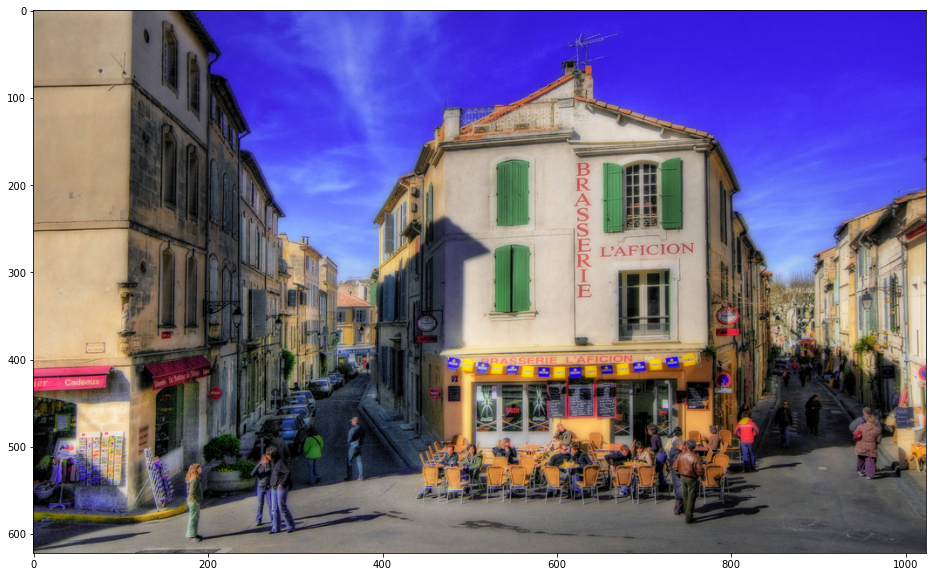

In [5]:
# Load the original image
img_path = "data/input_image/Brasserie_L_Aficion.png"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

#### Significance Maps

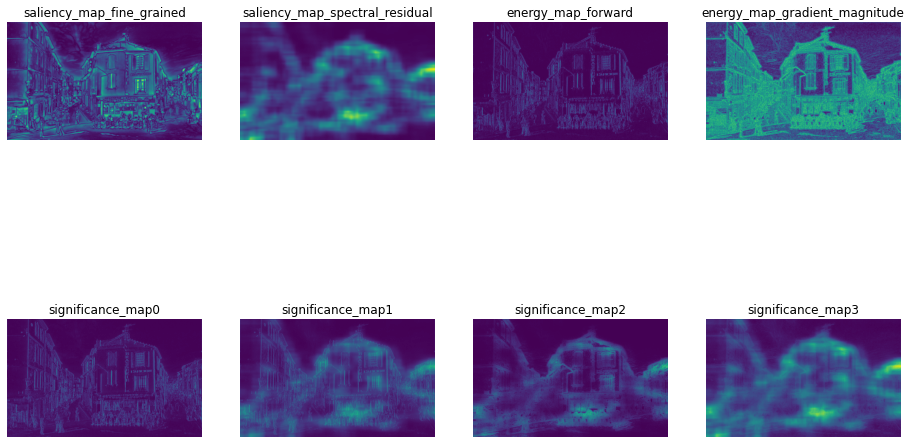

In [6]:
saliency_map_fine_grained = saliency_fine_grained(img)
saliency_map_spectral_residual = saliency_spectral_residual(img)
energy_map_forward = energy_forward(img)
energy_map_gradient_magnitude = energy_gradient_magnitude(img)
single_maps = [
    saliency_map_fine_grained,
    saliency_map_spectral_residual,
    energy_map_forward,
    energy_map_gradient_magnitude
]

significance_maps =[
    0.1 * saliency_map_fine_grained + 0.9 * energy_map_forward,
    0.5 * saliency_map_spectral_residual + 0.5 * energy_map_forward,
    saliency_map_spectral_residual * energy_map_gradient_magnitude,
    0.5 * saliency_map_spectral_residual + 0.5 * energy_map_gradient_magnitude
]

maps = OrderedDict({
    'saliency_map_fine_grained': saliency_map_fine_grained,
    'saliency_map_spectral_residual': saliency_map_spectral_residual,
    'energy_map_forward': energy_map_forward,
    'energy_map_gradient_magnitude': energy_map_gradient_magnitude
}) 
for i, significance_map in enumerate(significance_maps):
    maps['significance_map' + str(i)] = significance_map

plt.figure()
col_subfigure = 4
row_subfigure = 2
for i, (title, map) in enumerate(maps.items()):
    plt.subplot(row_subfigure, col_subfigure, i + 1)
    plt.gca().set_title(title)
    plt.imshow(map)
    plt.axis('off')

#### Test Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input image size: 622 x 1024
Output image size: 622 x 768
Time (optimization part): 0.171558 s
Time (warping part): 9.778083 s


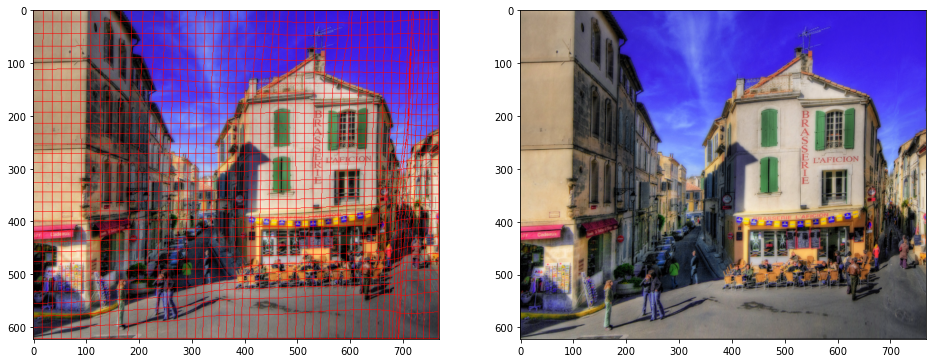

In [9]:
h_img, w_img, _ = img.shape
target_size = (int(1 * h_img), int(0.75 * w_img))
quad_size = 20
significance_map = significance_maps[1]
lambda_l = 10.0

vertices_init = initial_mesh_vertices(img, quad_size)
vertices_initial_guess = initial_guess_vertices(target_size, vertices_init)
quad_weights = significance_weights(significance_map, vertices_init)

# Get optimal vertices
t1 = time.monotonic()
vertices_new = optimize(vertices_init, vertices_initial_guess, quad_weights, lambda_l)
t2 = time.monotonic()
# Warp the image
warped_img = warp_img(img, vertices_init, vertices_new)
t3 = time.monotonic()

# Show results
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(visualize_mesh(warped_img, np.int64(vertices_new)))
plt.subplot(1, 2, 2)
plt.imshow(warped_img)
print('Input image size: %d x %d' % (h_img, w_img))
print('Output image size: %d x %d' % (target_size))
print('Time (optimization part): %f s' % (t2 - t1))
print('Time (warping part): %f s' % (t3 - t2))